# 01_BathymetryTransform

Regrid GEBCO Arctic Ocean Bathmetry to UniB sea ice concentration grid

## Import packages

In [1]:
import numpy as np
import xarray as xr

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import sys

# path to own functions
sys.path.append('../../')
import data_UniBremen.SIC as UNISIC

## Choose tagret grid to convert data

In [5]:
# ASI SIC 6.25 km grid
#---------------------
# SIC
data = {}
data['6250'] = UNISIC.open_remote_file(datetime(2021, 3, 24, 0, 0), 
                                      res = '6250', hem = 'n', method = 'urllib',
                                      area = True, include_units=False)

print(data['6250'].keys())

dict_keys(['proj', 'ds', 'x', 'y', 'xx', 'yy', 'sic', 'area'])


In [6]:
# ds = xr.Dataset({ "x": test_x,
#                  "y": test_y,
#                  "elev": test_elev})

# ds.to_netcdf(path='/Users/mackenziejewell/Desktop/ref_points.nc')



# convert ASI points to lat,lon so as not to run calcs below 55 degrees

In [7]:
TRANS_coords = ccrs.PlateCarree().transform_points(data['6250']['proj'], data['6250']['xx'], data['6250']['yy'])
trans_lon = TRANS_coords[:,:,0]
trans_lat = TRANS_coords[:,:,1]

## Open test points

In [8]:

ds = xr.open_dataset('/Users/mackenziejewell/Desktop/ref_points.nc')

test_x = ds.x.values
test_y = ds.y.values
test_elev = ds.elev.values

In [12]:
dx = np.diff(data['6250']['xx'], axis=1)[0][0]
dy = np.diff(data['6250']['yy'], axis=0)[0][0]

mean_elev = np.zeros(data['6250']['xx'].shape)
elev_5th = np.zeros(data['6250']['xx'].shape)
elev_25th = np.zeros(data['6250']['xx'].shape)
elev_50th = np.zeros(data['6250']['xx'].shape)
elev_75th = np.zeros(data['6250']['xx'].shape)
elev_95th = np.zeros(data['6250']['xx'].shape)
above_sealvl = np.zeros(data['6250']['xx'].shape)

In [13]:
data['6250']['xx'].shape

(1792, 1216)

In [ ]:
starttime = datetime.now()

# for ii in range(690, np.shape(mean_elev)[0]):
#     for jj in range(np.shape(mean_elev)[1]):

for ii in range(1000, 1250):
    for jj in range(0,600):
        
        if ii % 30 == 0:
            if jj % 500 == 0:
                print(ii, jj)
                
        if trans_lat[ii,jj] < 54:
            
            mean_elev[ii, jj] = np.nan
            elev_5th[ii, jj] = np.nan
            elev_25th[ii, jj] = np.nan
            elev_50th[ii, jj] = np.nan
            elev_75th[ii, jj] = np.nan
            elev_95th[ii, jj] = np.nan
            above_sealvl[ii, jj] = np.nan
        
        
        else:
            
            # current coordinates
            xc = data['6250']['xx'][ii,jj]
            yc = data['6250']['yy'][ii,jj]

            # ranges within each box
            xcond = (test_x >= xc - dx/2) & (test_x < xc + dx/2)
            ycond = (test_y >= yc - dy/2) & (test_y < yc + dy/2)

            if len(test_elev[(xcond) & (ycond)]) != 0:

                # calc values
                mean_elev[ii, jj] = np.nanmean(test_elev[(xcond) & (ycond)])
                elev_5th[ii, jj] = np.nanpercentile(test_elev[(xcond) & (ycond)], 5)
                elev_25th[ii, jj] = np.nanpercentile(test_elev[(xcond) & (ycond)], 25)
                elev_50th[ii, jj] = np.nanpercentile(test_elev[(xcond) & (ycond)], 50)
                elev_75th[ii, jj] = np.nanpercentile(test_elev[(xcond) & (ycond)], 75)
                elev_95th[ii, jj] = np.nanpercentile(test_elev[(xcond) & (ycond)], 95)
                above_sealvl[ii, jj] = np.sum(test_elev[(xcond) & (ycond)]>0) / len(test_elev[(xcond) & (ycond)])


            else:

                mean_elev[ii, jj] = np.nan
                elev_5th[ii, jj] = np.nan
                elev_25th[ii, jj] = np.nan
                elev_50th[ii, jj] = np.nan
                elev_75th[ii, jj] = np.nan
                elev_95th[ii, jj] = np.nan
                above_sealvl[ii, jj] = np.nan

            
print(f'runtime >>> {datetime.now() - starttime}')
            

1020 0
1020 500
1050 0
1050 500
1080 0
1080 500
1110 0
1110 500
1140 0
1140 500
1170 0
1170 500
1200 0
1200 500


In [ ]:
# expecting it to take 72 hours from Nov 8 @ 9 am

In [4]:
(100 / 30)*72

240.0

In [150]:
mean_elev.shape

(1792, 1216)

In [151]:
(ii*jj)/(1792*1216)

0.1812744140625

In [160]:
print(ii, jj)

693 570


In [ ]:

# # construct ds

# # variables
# data_vars = {}

# data_vars['avg']= (('yy', 'xx'), mean_elev, {'long_name':'mean', 'units':'m'})
# data_vars['5th']= (('yy', 'xx'), elev_5th, {'long_name':'mean', 'units':'m'})
# data_vars['25th']= (('yy', 'xx'), elev_25th, {'long_name':'mean', 'units':'m'})
# data_vars['50th']= (('yy', 'xx'), elev_50th, {'long_name':'mean', 'units':'m'})
# data_vars['75th']= (('yy', 'xx'), elev_75th, {'long_name':'mean', 'units':'m'})
# data_vars['95th']= (('yy', 'xx'), elev_95th, {'long_name':'mean', 'units':'m'})
# data_vars['N_abv_slvl']= (('yy', 'xx'), above_sealvl, {'long_name':'# above sea level', 'units':'#'})

# # coordinates
# coords = {'yy': data['6250']['yy'][:,0], 'xx': data['6250']['xx'][0,:]}

# # attributes
# attrs = {}
# attrs['descript'] = 'UniBremen 6.25 km data, with estimated bathymetry from GEBCO'
# attrs['ii'] = '1000:1250'
# attrs['jj'] = '0:600'

# # Create the dataset
# ds = xr.Dataset(
#     data_vars = data_vars,
#     coords = coords,
#     attrs = attrs,    
# )

# ds.to_netcdf(path=f"/Users/mackenziejewell/Desktop/elevation_files/Elevation_V5.nc")



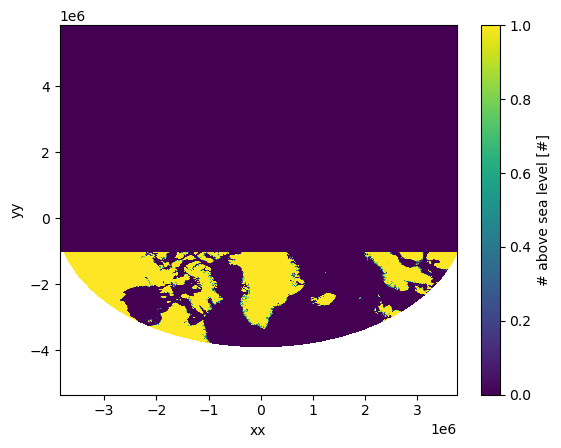

In [164]:
(ds['N_abv_slvl']).plot()